## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import sparse
from surprise import Dataset, Reader, SVD
from collections import Counter

In [3]:
df = pd.read_csv("training_data/data.csv")
df.head()

,user_id,song_id,listen_count,timestamp,interaction
0,76,453,1,2024-04-01 23:25:01.108907,1
1,93,58,2,2024-12-25 23:16:01.109108,2
2,22,355,0,2024-06-24 03:58:01.109114,-1
3,64,215,1,2024-09-08 15:46:01.109118,-1
4,9,149,4,2024-10-20 23:35:01.109122,2


## Data Analysis

### User Behaviour Analysis

Average number of listens per user: 44.59
Most active users: [0, 29, 2, 52, 59, 73, 97, 88, 30, 18] and Most Inactive Users: [87, 3, 77, 54, 51, 75, 24, 9, 82, 5]


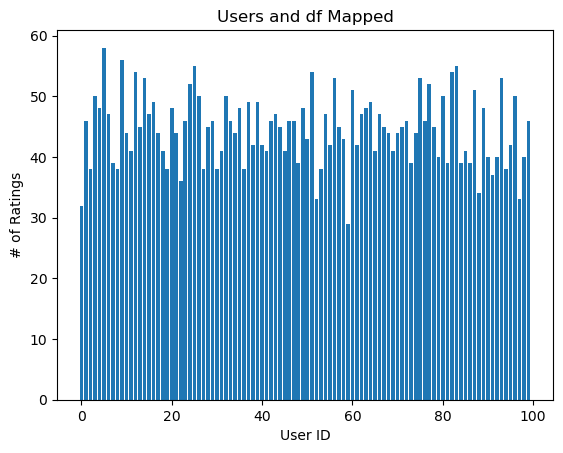

In [6]:
# users = Counter(sorted(df["user_id"]))
users = df["user_id"].value_counts()

# plot user df
plt.title("Users and df Mapped")
plt.bar(users.index,users.values)
plt.xlabel("User ID")
plt.ylabel("# of Ratings")

# average listens per user
average_ratings_per_user = users.mean()
print("Average number of listens per user:",average_ratings_per_user)

# top 10 active/inactive users
listen_count_users = df.groupby("user_id")["listen_count"].sum()
sorted_users = listen_count_users.sort_values(ascending=True)
top_active_users = list(sorted_users.index[:10])
top_inactive_users = list(sorted_users.index[-10:])
print(f'Most active users: {top_active_users} and Most Inactive Users: {top_inactive_users}')


### Song Analysis

Number of unique songs: 378
Number of unlistened songs: 4
Most played songs: [180, 26, 105, 499, 46] and Least played songs: [379, 150, 84, 340, 418]


Text(0, 0.5, 'Number of Listens')

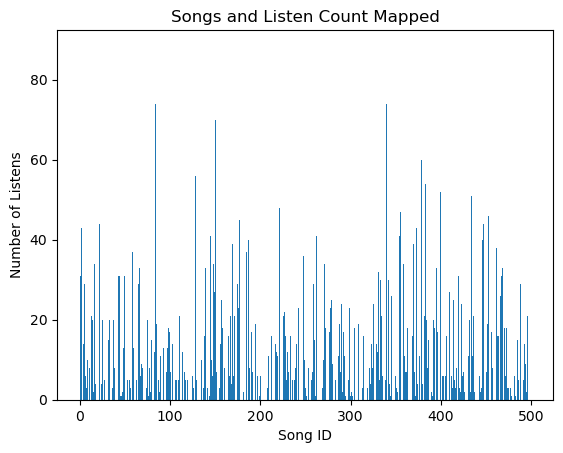

In [8]:
songs = df["song_id"]

# number of songs
unique_songs = songs.nunique()
print(f'Number of unique songs: {unique_songs}')

# check for unrated songs
all_songs = songs.unique()
listen_count = df.groupby("song_id")["listen_count"].sum()
listen_count = listen_count.reindex(all_songs, fill_value=0)
unplayed = (listen_count == 0).sum()
print(f'Number of unlistened songs: {unplayed}')

#top 5 most/least played songs
sorted_listen_count = listen_count.sort_values(ascending=True)
top_played_songs = list(sorted_listen_count.index[:5])
least_played_songs = list(sorted_listen_count.index[-5:])
print(f'Most played songs: {top_played_songs} and Least played songs: {least_played_songs}')


# plot listen counts
plt.title("Songs and Listen Count Mapped")
plt.bar(listen_count.index, listen_count.values)
plt.xlabel("Song ID")
plt.ylabel("Number of Listens")


### Rating Patterns

Text(0, 0.5, 'Frequency')

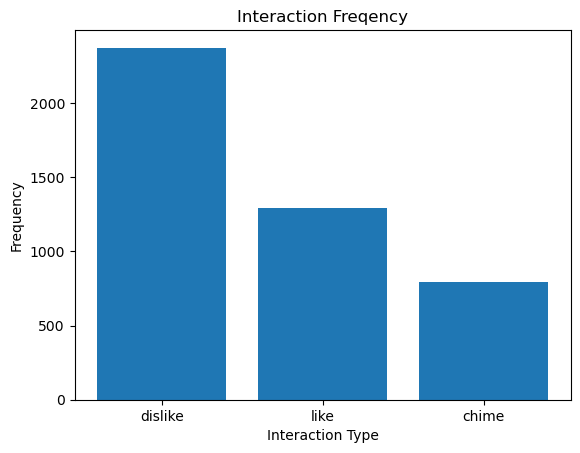

In [10]:
# ratings chart
ratings = df["interaction"].value_counts()
interaction_type = ["dislike","like","chime"]
plt.title("Interaction Freqency")
plt.bar(interaction_type, ratings.values)
plt.xlabel("Interaction Type")
plt.ylabel("Frequency")

### Matrix Sparsity

In [12]:
user_item_matrix = df.pivot(
    index='user_id',
    columns='song_id',
    values='interaction'
)

# handling empty values
user_item_matrix = user_item_matrix.fillna(0)
sparsity = 1.0 - np.count_nonzero(user_item_matrix) / user_item_matrix.size
print(f"Matrix sparsity: {sparsity:.2%}")


Matrix sparsity: 88.20%


## Data Preprocessing

In [14]:
from scipy.sparse import csr_matrix
# compressed sparse row

sparse_matrix = csr_matrix(user_item_matrix.values)
sparse_matrix.shape

# 3 methods to explore: time-based splitting, leave-one-out, random splitting with user stratification

(100, 378)

### Time-based splitting

In [16]:
df_sorted  = df.sort_values("timestamp")

# determine split point (we'll be doing 80/20 split testing)
split_idx = int(len(df_sorted)*0.8)

df_train = df_sorted.iloc[:split_idx] #training set
df_test = df_sorted.iloc[split_idx:] #testing set

#check for users and songs in test that aren't in training
#can't make good predictions for completely new users/songs
all_users = sorted(set(df["user_id"]))
all_songs = sorted(set(df["song_id"]))

#training matrix
train_matrix = df_train.pivot(
    index="user_id",
    columns="song_id",
    values="interaction"
).fillna(0)

train_matrix = train_matrix.reindex(index=all_users, columns=all_songs,fill_value=0)
train_sparse = csr_matrix(train_matrix.values)

#testing matrix
test_matrix = df_test.pivot(
    index="user_id",
    columns="song_id",
    values="interaction"
).fillna(0)
test_matrix = test_matrix.reindex(index=all_users, columns=all_songs,fill_value=0)
test_sparse = csr_matrix(test_matrix.values)

#reindex used to ensure both test and train matrices have the same dimensions (size should be # of user-song combinations)
#check size
print(f'Size of Train matrix: {train_matrix.shape}    Size of Test matrix: {test_matrix.shape}')

Size of Train matrix: (100, 378)    Size of Test matrix: (100, 378)


### Leave-one-out method

In [43]:
# random interacton set
# returns a groupby object, takes one sample entry per user
test_rn_interactions = df.groupby("user_id").sample(n=1)
#train set
train_rn_interactions = df.drop(test_rn_interactions.index)

# latest interaction set
test_new_interactions = df.sort_values("timestamp").groupby("user_id").tail(1)
train_new_interactions = df.drop(test_new_interactions.index)


### Random Splits with User Stratification

In [86]:
from sklearn.model_selection import train_test_split

# number of interactions per user
interaction_count = df.groupby("user_id").size() #groups number of interactions by user, index is id and value is # of interactions
stratification_labels = ["low","medium","high"]
bins = pd.qcut(interaction_count, q=3, labels=stratification_labels) #divides series into equal sized bins
# result: series, index is id, value is label

user_bins = interaction_count.map(bins)

unique_users = interaction_count.index

x_train, x_test = train_test_split(unique_users,test_size=0.2,stratify=user_bins)

## Training with SVD

In [150]:
from surprise import SVD,Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split

data_for_surprise = df[['user_id', 'song_id', 'interaction']]

#reader parses the interaction values range
reader = Reader(rating_scale=(-1,2))

#converts panda df into surprise compatible dataset
data = Dataset.load_from_df(
    data_for_surprise, 
    reader)

trainset, testset = train_test_split(data,test_size=0.2)

model=SVD(
    n_factors = 50, # number of features/dimensions for the users/items
    n_epochs=50, # number of iterations
    lr_all=0.005, # learning rate
    reg_all=0.02 # regularization parameter
)
model.fit(trainset)

'''
note: fit() method requires s training set format created by surprise library, hence the additional processing
'''

'\nnote: fit() method requires s training set format created by surprise library, hence the additional processing\n'

## Testing

In [146]:
from surprise import accuracy
from sklearn.metrics import classification_report


predictions = model.test(testset)
for pred in predictions[:5]:
    print(pred)
accuracy.rmse(predictions)
accuracy.mae(predictions)

def discretize_prediction(pred):
    if pred < 0: return -1
    elif pred < 1.5: return 1
    else: return 2

actual = [pred.r_ui for pred in predictions]
predicted = [discretize_prediction(pred.est) for pred in predictions]

# Classification metrics
print(classification_report(actual, predicted, target_names=["Dislike (-1)", "Like (1)", "Superlike (2)"]))
#r_ui = actual rating, est = predicted rating

user: 9          item: 358        r_ui = -1.00   est = -0.17   {'was_impossible': False}
user: 47         item: 56         r_ui = -1.00   est = 0.07   {'was_impossible': False}
user: 89         item: 171        r_ui = 1.00   est = -0.67   {'was_impossible': False}
user: 80         item: 215        r_ui = 2.00   est = 0.54   {'was_impossible': False}
user: 85         item: 384        r_ui = 1.00   est = 0.61   {'was_impossible': False}
RMSE: 1.1967
MAE:  1.0636
               precision    recall  f1-score   support

 Dislike (-1)       0.67      0.54      0.60       486
     Like (1)       0.35      0.68      0.46       254
Superlike (2)       0.33      0.01      0.01       152

     accuracy                           0.49       892
    macro avg       0.45      0.41      0.36       892
 weighted avg       0.52      0.49      0.46       892



In [ ]:
## embeddings into cosine similarity